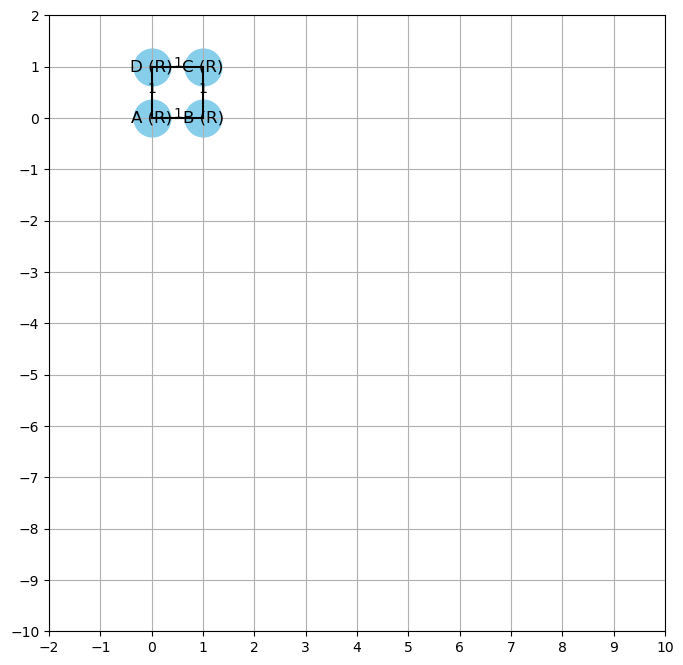

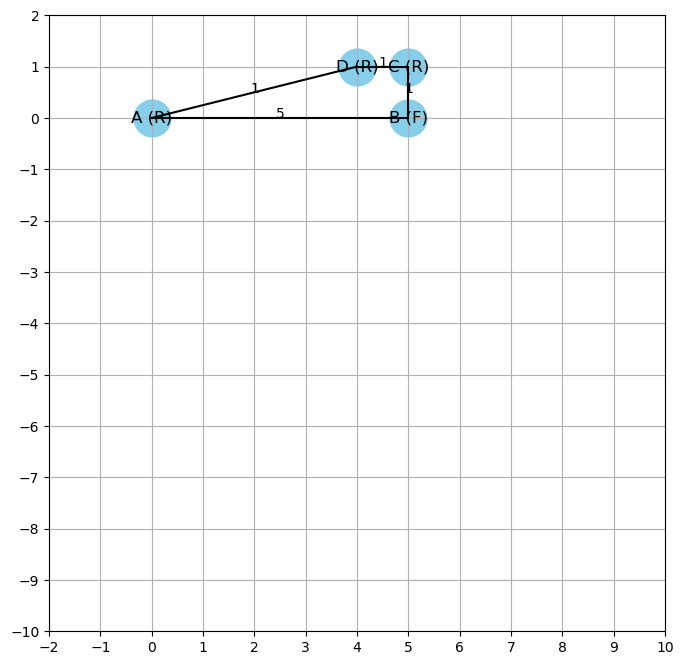

In [47]:
import matplotlib.pyplot as plt
import networkx as nx

class Vertex:
    def __init__(self, label, angle_type='F'):
        self.label = label
        self.angle_type = angle_type
        self.edges = {}

class Edge:
    def __init__(self, start, end, weight=1, direction=None):
        self.start = start
        self.end = end
        self.weight = weight
        self.length = weight
        self.direction = direction

class WeightedGraph:
    def __init__(self):
        self.vertices = {}

    def add_vertex(self, key, angle_type='F'):
        if key not in self.vertices:
            self.vertices[key] = Vertex(key, angle_type)

    def add_edge(self, start, end, weight=1, direction=None):
        if start in self.vertices and end in self.vertices:
            edge = Edge(start, end, weight, direction)
            self.vertices[start].edges[end] = edge

    def update_vertex_angle_type(self, vertex_key, new_angle_type):
        if vertex_key in self.vertices:
            self.vertices[vertex_key].angle_type = new_angle_type

    def update_edge(self, start, end, new_length=None, new_direction=None):
        if start in self.vertices and end in self.vertices[start].edges:
            edge = self.vertices[start].edges[end]
            if new_length is not None:
                edge.length = new_length
            if new_direction is not None:
                edge.direction = new_direction

    def change_edge_length(self, start, end, new_length):
        self.update_edge(start, end, new_length=new_length)

    def remove_vertex(self, key):
        if key in self.vertices:
            del self.vertices[key]
            for vertex in self.vertices.values():
                if key in vertex.edges:
                    del vertex.edges[key]

    def calculate_positions(self, start_key='A'):
        pos = {start_key: (0, 0)}
        grid_size = 1

        def place_vertex(vertex_key, x, y):
            pos[vertex_key] = (x, y)
            for end_key, edge in self.vertices[vertex_key].edges.items():
                if end_key in self.vertices and end_key not in pos:
                    length = edge.length * grid_size
                    if edge.direction == 'E':
                        new_x = x + length
                        place_vertex(end_key, new_x, y)
                    elif edge.direction == 'S':
                        new_y = y - length
                        place_vertex(end_key, x, new_y)
                    elif edge.direction == 'W':
                        new_x = x - length
                        place_vertex(end_key, new_x, y)
                    elif edge.direction == 'N':
                        new_y = y + length
                        place_vertex(end_key, x, new_y)

        if start_key in self.vertices:
            place_vertex(start_key, 0, 0)
        return pos

    def draw_edges_with_bends(self, G, pos):
        drawn_edges = set()
        for vertex_key in self.vertices:
            if vertex_key not in pos:
                continue
            for end_key, edge in self.vertices[vertex_key].edges.items():
                edge_key = (vertex_key, end_key)
                if edge_key not in drawn_edges and end_key in pos:
                    x_start, y_start = pos[vertex_key]
                    x_end, y_end = pos[end_key]
                    plt.plot([x_start, x_end], [y_start, y_end], 'k-')
                    drawn_edges.add(edge_key)

    def print_graph(self):
        for key, vertex in self.vertices.items():
            edges_info = ', '.join([f"{end} (weight: {edge.weight}, {edge.direction})" for end, edge in vertex.edges.items()])
            print(f"Vertex: {key}, Angle Type: {vertex.angle_type}, Edges: {edges_info if edges_info else 'No edges'}")


    def draw_graph(self):
        G = nx.DiGraph()
        pos = self.calculate_positions()

        plt.figure(figsize=(8, 8))
        self.draw_edges_with_bends(G, pos)

        for key, vertex in self.vertices.items():
            if key in pos:
                plt.scatter(*pos[key], s=700, c='skyblue')
                plt.text(pos[key][0], pos[key][1], f"{vertex.label} ({vertex.angle_type})", fontsize=12, ha='center', va='center')

        plt.grid(True)
        plt.xlim(-2, 10)
        plt.ylim(-10, 2)
        plt.xticks(range(-2, 11))
        plt.yticks(range(-10, 3))
        plt.gca().set_aspect('equal', adjustable='box')

        for vertex_key in self.vertices:
            if vertex_key in pos:
                for end_key in self.vertices[vertex_key].edges:
                    if end_key in pos:
                        edge_length = self.vertices[vertex_key].edges[end_key].length
                        plt.text((pos[vertex_key][0] + pos[end_key][0]) / 2, (pos[vertex_key][1] + pos[end_key][1]) / 2, str(edge_length), fontsize=10, ha='center')

        plt.show()

wg = WeightedGraph()
wg.add_vertex('A',  'R')
wg.add_vertex('B', 'R')
wg.add_vertex('C',  'R')
wg.add_vertex('D',  'R')
wg.add_edge('A', 'B', 1, 'E')
wg.add_edge('B', 'C', 1, 'N')
wg.add_edge('C', 'D', 1, 'W')
wg.add_edge('D', 'A', 1, 'S')

wg.draw_graph()

wg.change_edge_length('A', 'B', 5)
wg.update_vertex_angle_type('B', 'F')
wg.draw_graph()

[['A', 'B', 'C', 'D']]
Vertex: A, Angle Type: R, Edges: B (weight: 1, E)
Vertex: B, Angle Type: F, Edges: C (weight: 1, E)
Vertex: C, Angle Type: F, Edges: D (weight: 1, E)
Vertex: D, Angle Type: R, Edges: E (weight: 1, S)
Vertex: E, Angle Type: R, Edges: F (weight: 3, W)
Vertex: F, Angle Type: R, Edges: A (weight: 1, N)


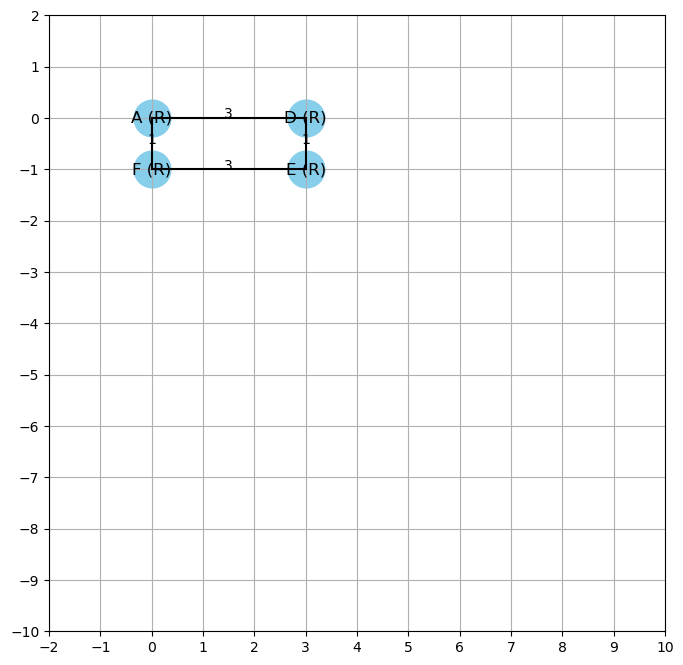

Vertex: A, Angle Type: R, Edges: D (weight: 3, E)
Vertex: D, Angle Type: R, Edges: E (weight: 1, S)
Vertex: E, Angle Type: R, Edges: F (weight: 3, W)
Vertex: F, Angle Type: R, Edges: A (weight: 1, N)


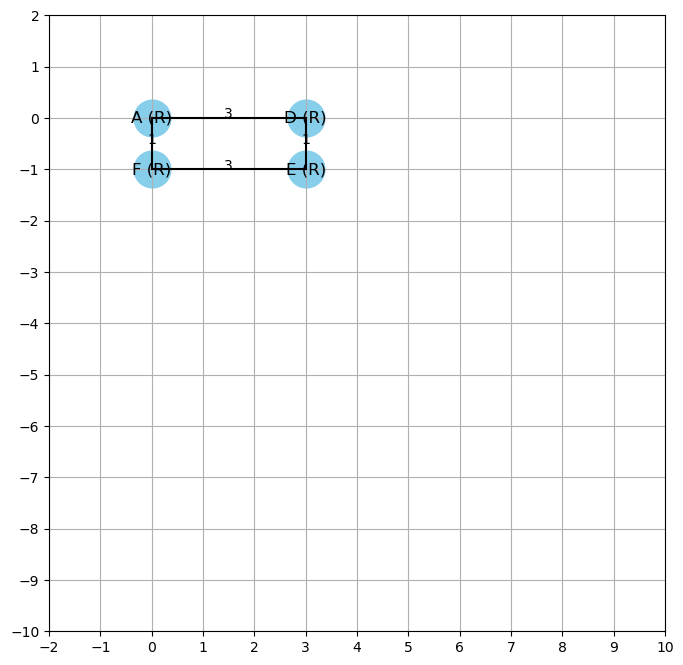

In [50]:
def list_all_paths_with_F_angle(wg):
    def find_paths(start, end, path=None, paths=None):
        if path is None:
            path = []
        if paths is None:
            paths = []
        path = path + [start]
        if start == end:
            if len(path) >= 3:
                if all(wg.vertices[v].angle_type == 'F' for v in path[1:-1]):
                    paths.append(path)
            return paths
        for neighbor in wg.vertices[start].edges.keys():
            if neighbor not in path:
                find_paths(neighbor, end, path, paths)
        return paths

    all_paths = []
    for start in wg.vertices.keys():
        if wg.vertices[start].angle_type != 'F':
            for end in wg.vertices.keys():
                if start != end and wg.vertices[end].angle_type != 'F':
                    paths = find_paths(start, end)
                    all_paths.extend(paths)
    return all_paths
    


def reduction1(wg):
    paths = list_all_paths_with_F_angle(wg)

    for path in paths:
        if len(path) < 3:
            continue
        
        start = path[0]
        end = path[-1]
        
        total_weight = sum(wg.vertices[path[i]].edges[path[i + 1]].weight for i in range(len(path) - 1))
        
        direction = wg.vertices[path[0]].edges[path[1]].direction if path[1] in wg.vertices[path[0]].edges else None
        wg.add_edge(start, end, total_weight, direction)

        for vertex in path[1:-1]:
            wg.remove_vertex(vertex)
                

wg = WeightedGraph()

wg.add_vertex('A',  'R')
wg.add_vertex('B', 'F')
wg.add_vertex('C', 'F')
wg.add_vertex('D', 'R')
wg.add_vertex('E', 'R')
wg.add_vertex('F', 'R')

wg.add_edge('A','B',1,'E')
wg.add_edge('B','C',1,'E')
wg.add_edge('C','D',1,'E')
wg.add_edge('D','E',1,'S')
wg.add_edge('E','F',3,'W')
wg.add_edge('F','A',1,'N')


print(list_all_paths_with_F_angle(wg))

wg.print_graph()
reduction1(wg)
wg.draw_graph()
wg.print_graph()
wg.draw_graph()




